The problem
We have some data coming from one continuous EEG (i.e. Electroencephalogram measurement with the Emovtiv EEG neuroheadset which is this device below: 
Now, in the dataset we're about to explore, we have the measures for all these points (except CMS and DRL):

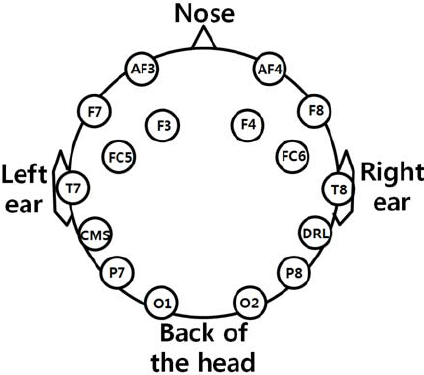

In [12]:
from IPython import display
display.Image("1.png")

We also have the indication of the open state of the eye which will be our target value. Because we will try to train a nice model which can predict depending of the measurements points if the eye is opened or not.

In [1]:
# Basics
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from scipy.stats import norm

#!pip install termcolor
from termcolor import colored

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
#Deep learning 
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, GRU,Bidirectional,BatchNormalization,PReLU,ReLU,Reshape

In [1]:
import pandas as pd

In [46]:
df = pd.read_csv("data/EEG_Eye_State_Classification.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [5]:
df.head()

AF3       F7       F3      FC5       T7       P7       O1       O2  \
0  4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03   
1  4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
2  4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
3  4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
4  4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   

        P8       T8      FC6       F4       F8      AF4  eyeDetection  
0  4222.05  4238.46  4211.28  4280.51  4635.90  4393.85             0  
1  4210.77  4226.67  4207.69  4279.49  4632.82  4384.10             0  
2  4207.69  4222.05  4206.67  4282.05  4628.72  4389.23             0  
3  4217.44  4235.38  4210.77  4287.69  4632.31  4396.41             0  
4  4210.77  4244.10  4212.82  4288.21  4632.82  4398.46             0

In [6]:
print(df.shape)
print(colored("Shape of the dataset:", "green", attrs=['bold', 'underline']))
print(colored(f"\t{df.shape[0]} rows", "green"))
print(colored(f"\t{df.shape[1]} columns", "green"))

(14980, 15)
Shape of the dataset:
	14980 rows
	15 columns


In [7]:
df.describe()

AF3            F7            F3            FC5            T7  \
count   14980.000000  14980.000000  14980.000000   14980.000000  14980.000000   
mean     4321.917777   4009.767694   4264.022433    4164.946326   4341.741075   
std      2492.072174     45.941672     44.428052    5216.404632     34.738821   
min      1030.770000   2830.770000   1040.000000    2453.330000   2089.740000   
25%      4280.510000   3990.770000   4250.260000    4108.210000   4331.790000   
50%      4294.360000   4005.640000   4262.560000    4120.510000   4338.970000   
75%      4311.790000   4023.080000   4270.770000    4132.310000   4347.180000   
max    309231.000000   7804.620000   6880.510000  642564.000000   6474.360000   

                  P7             O1            O2             P8  \
count   14980.000000   14980.000000  14980.000000   14980.000000   
mean     4644.022379    4110.400160   4616.056904    4218.826610   
std      2924.789537    4600.926543     29.292603    2136.408523   
min      2768.210000    2086.150000   4567.180000    1357.950000   
25%      4611.790000    4057.950000   4604.620000    4190.770000   
50%      4617.950000    4070.260000   4613.330000    4199.490000   
75%      4626.670000    4083.590000   4624.100000    4209.230000   
max    362564.000000  567179.000000   7264.100000  265641.000000   

                 T8           FC6            F4             F8            AF4  \
count  14980.000000  14980.000000  14980.000000   14980.000000   14980.000000   
mean    4231.316200   4202.456900   4279.232774    4615.205336    4416.435832   
std       38.050903     37.785981     41.544312    1208.369958    5891.285043   
min     1816.410000   3273.330000   2257.950000      86.666700    1366.150000   
25%     4220.510000   4190.260000   4267.690000    4590.770000    4342.050000   
50%     4229.230000   4200.510000   4276.920000    4603.080000    4354.870000   
75%     4239.490000   4211.280000   4287.180000    4617.440000    4372.820000   
max     6674.360000   6823.080000   7002.560000  152308.000000  715897.000000   

       eyeDetection  
count  14980.000000  
mean       0.448798  
std        0.497388  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

In [8]:
df.isnull().sum()

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

<Axes: >

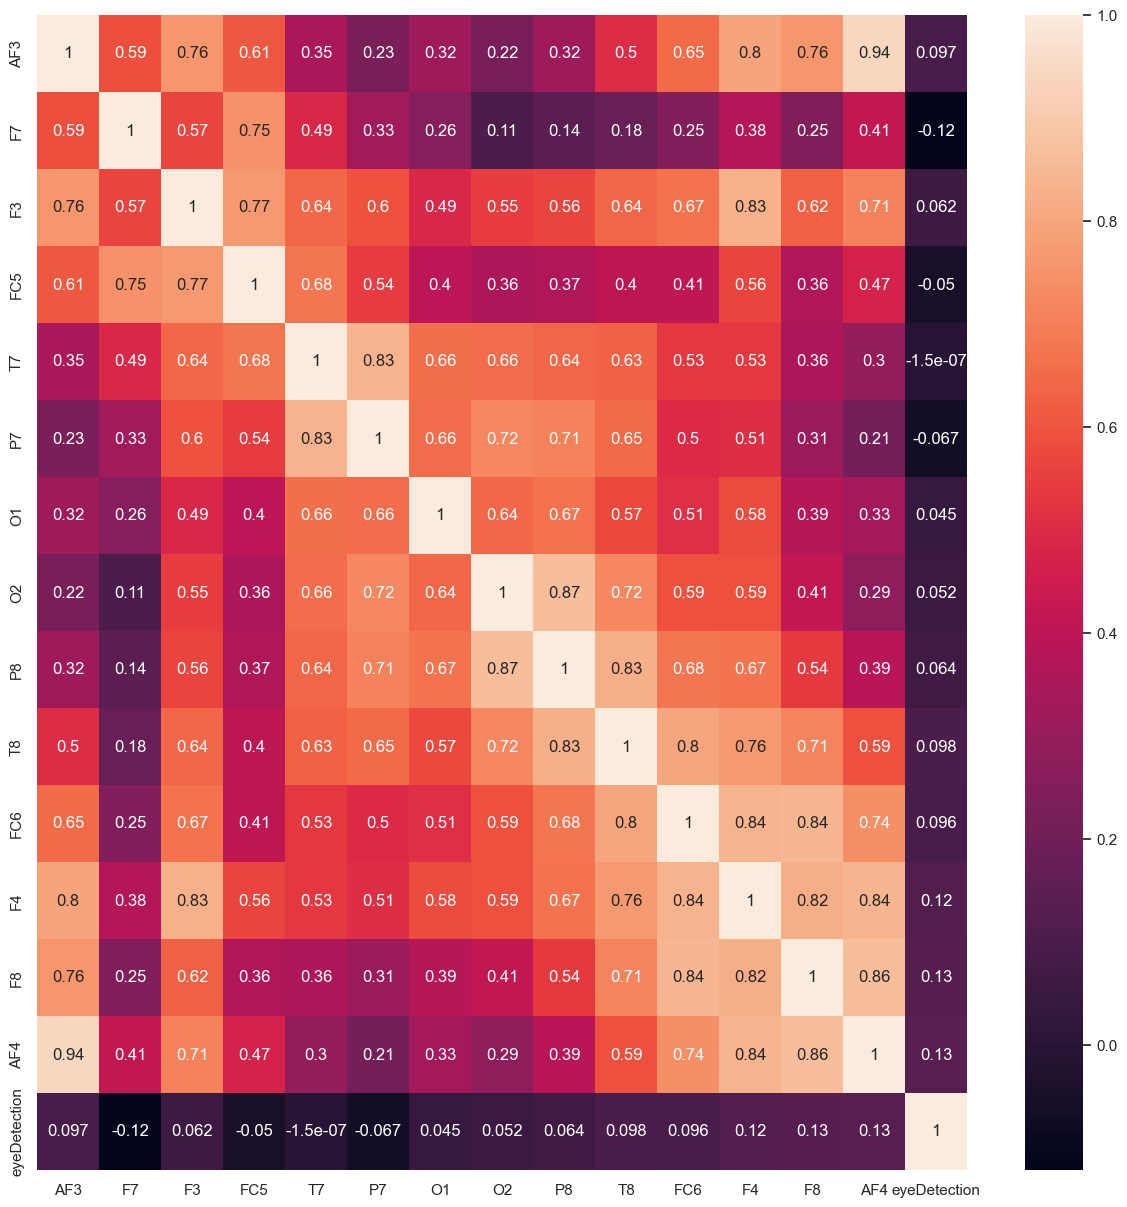

In [37]:
plt.figure(figsize = (15,15))
cor_matrix = df.corr()
sns.heatmap(cor_matrix,annot=True)

Text(0.5, 1.0, 'Target distribution')

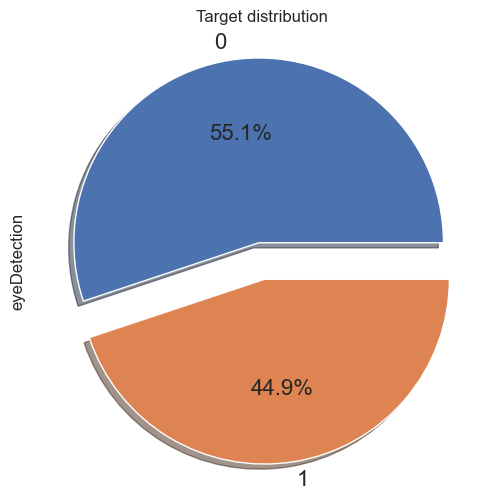

In [38]:
# Plotting target distribution 
plt.figure(figsize=(6,6))
df['eyeDetection'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

In [94]:
import scipy.stats as stats

In [96]:
# plot to check the cleaned data
def plot_data(X, xlim=[0, 20]):
    plt.figure(figsize=(15, 12) )
    
    for ind_data, data in enumerate(X):
        if ind_data == len(X) - 1:
            for ind, col in enumerate(data.columns.tolist()):
                plt.plot(t, 5 * ind + stats.zscore(data[col], nan_policy='omit'), linewidth=0.5, label=col)
            plt.legend(ncol=6)
        else:
            for ind, col in enumerate(data.columns.tolist()):
                plt.plot(t, 5 * ind + stats.zscore(data[col], nan_policy='omit'), linewidth=0.3, alpha=0.6, color='k', label=None)
    plt.xlim(xlim)

In [98]:
df.iloc[:, :-1].head()

AF3       F7       F3      FC5       T7       P7       O1       O2  \
0  4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03   
1  4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
2  4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
3  4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
4  4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   

        P8       T8      FC6       F4       F8      AF4  
0  4222.05  4238.46  4211.28  4280.51  4635.90  4393.85  
1  4210.77  4226.67  4207.69  4279.49  4632.82  4384.10  
2  4207.69  4222.05  4206.67  4282.05  4628.72  4389.23  
3  4217.44  4235.38  4210.77  4287.69  4632.31  4396.41  
4  4210.77  4244.10  4212.82  4288.21  4632.82  4398.46

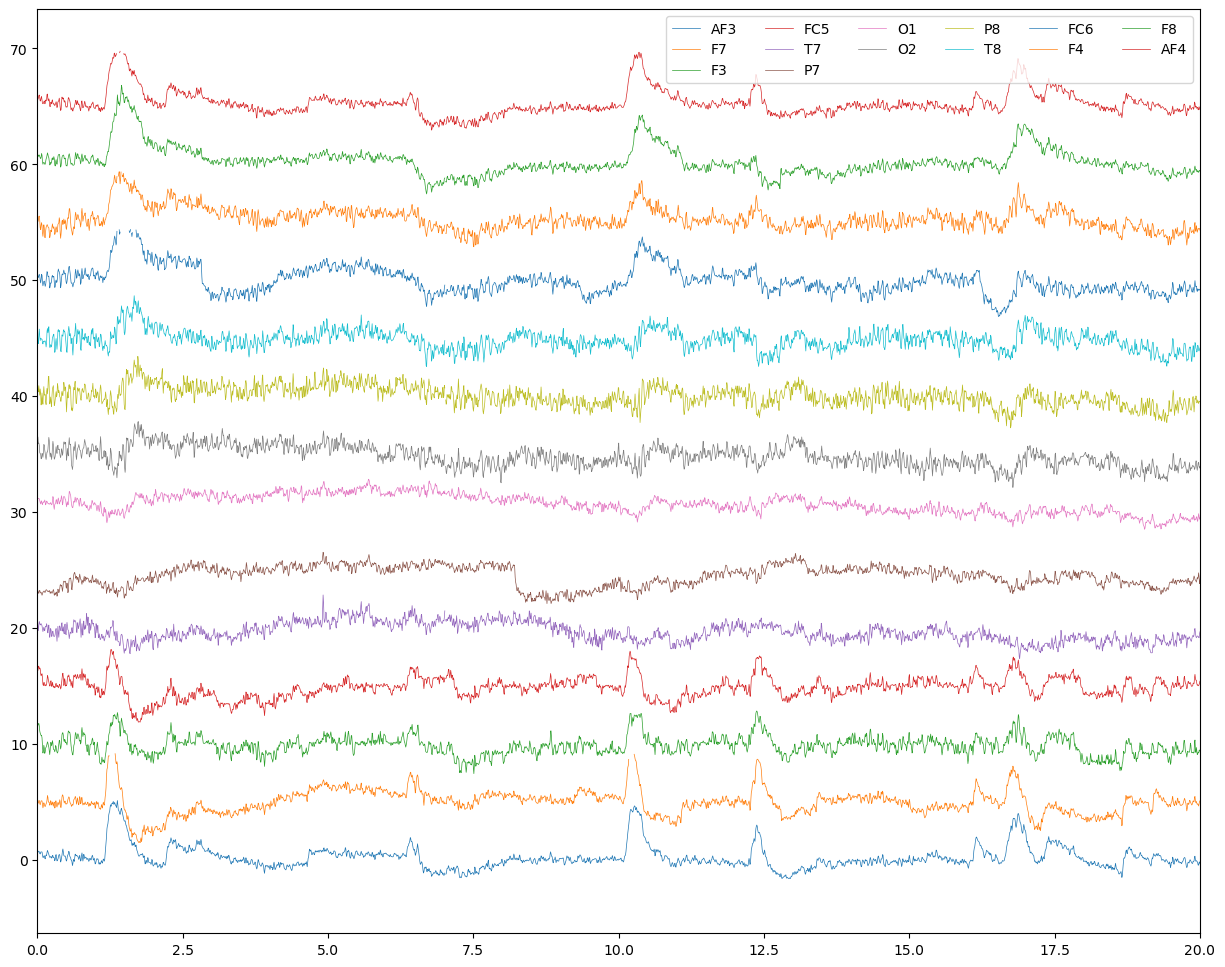

In [106]:
Fs = 128 # (number of samples / 117s length of data mentioned on the data description) rounded to the closest integer.
t = np.arange(0, len(df) * 1 / Fs, 1/Fs)
cols = df.columns.tolist()[:-1]
X=df.iloc[:, :-1]
#Find outliers and put Nan instead
X = X.apply(stats.zscore, axis=0)
X = X.applymap(lambda x: np.nan if (abs(x) > 4) else x )

# # recalculate outliers with ignoring nans since the first calculation was biased with the huge outliers!
X = X.apply(stats.zscore, nan_policy='omit', axis=0)
X = X.applymap(lambda x: np.nan if (abs(x) > 4) else x )

plot_data([X])

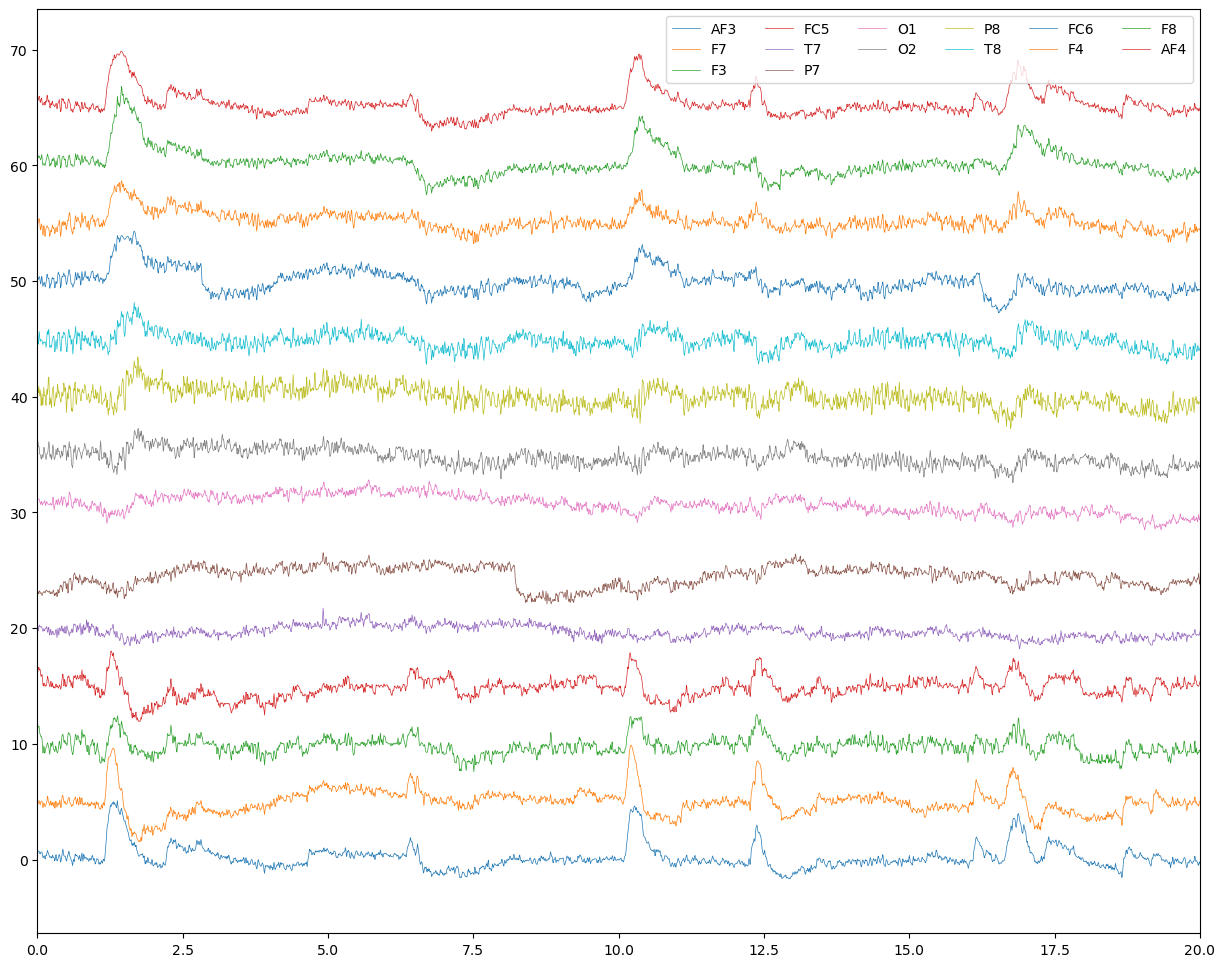

In [107]:
from scipy import signal, interpolate

def interp(x):
    t_temp = t[ x.index[ ~x.isnull() ] ]
    x = x[ x.index[ ~x.isnull() ] ]
    clf = interpolate.interp1d(t_temp, x, kind='cubic')
    return clf(t)

# interpolate the nans using cubic spline method
X_interp = X.apply(interp, axis=0)

plot_data([X_interp])

c:\Users\mahan\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


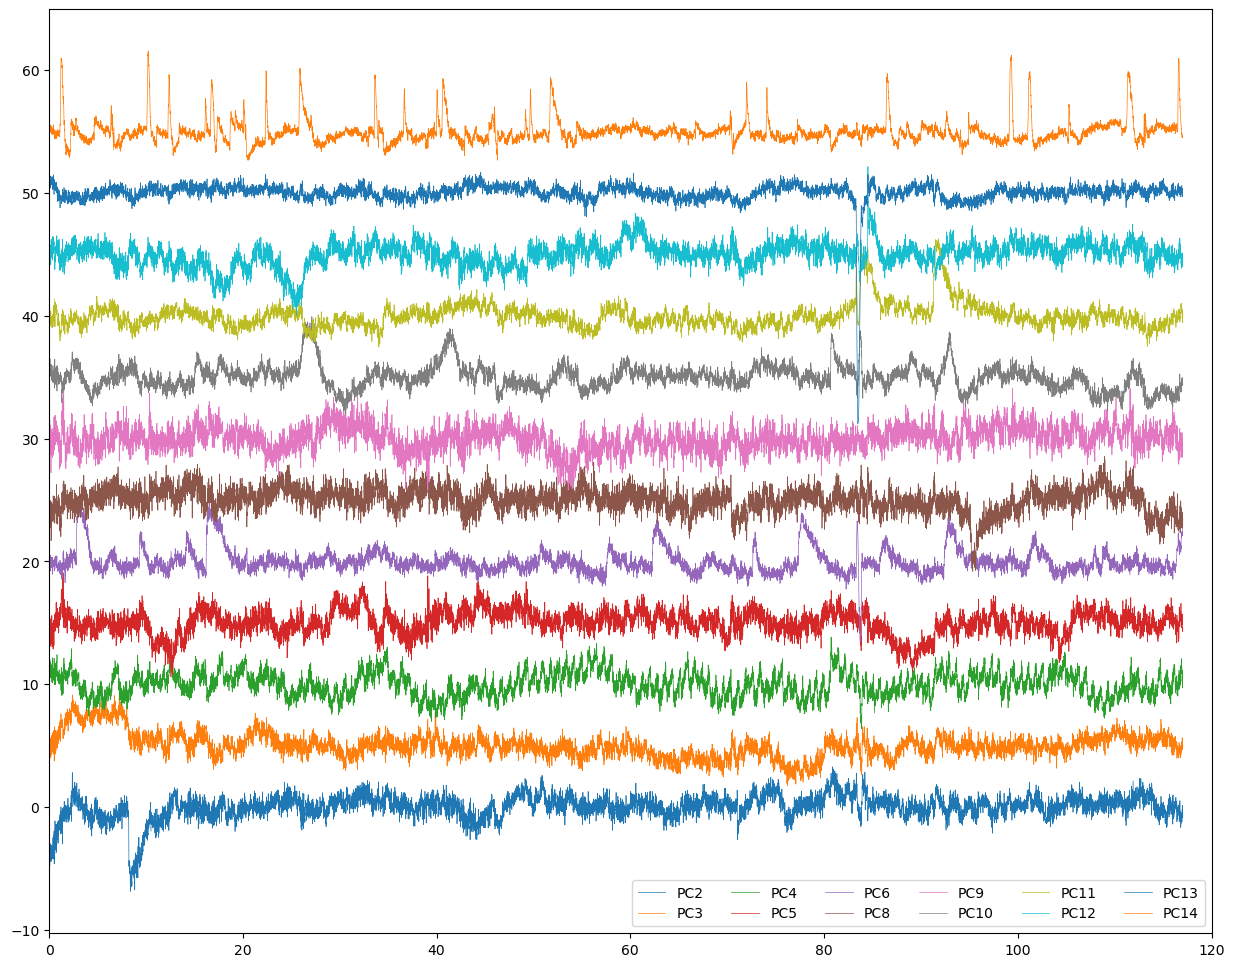

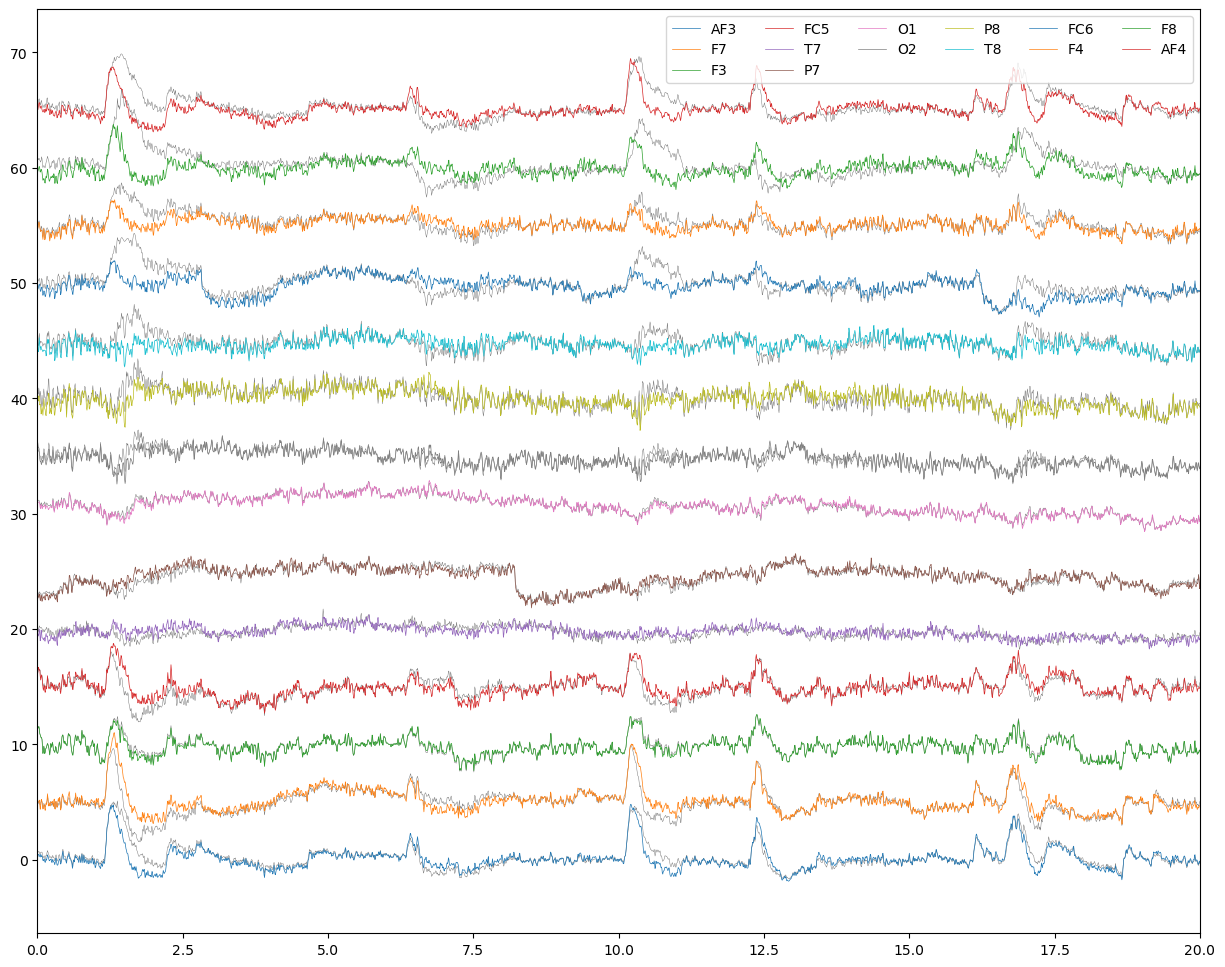

In [108]:
# ICA
from sklearn.decomposition import FastICA

# apply ICA to drop non-electrophysiolgoical components (requires familiarity with EEG data)
ica = FastICA(max_iter=2000, random_state=0)
X_pcs = pd.DataFrame( ica.fit_transform(X_interp) )
X_pcs.columns = ['PC' + str(ind+1) for ind in range(X_pcs.shape[-1])]
X_pcs = X_pcs.drop(columns=['PC1', 'PC7'])
plot_data([X_pcs], xlim=[0, 120])

# reconstruct clean EEG after dropping the bad components
ica.mixing_ = np.delete(ica.mixing_, [0, 6], axis = 1)
X_interp_clean = pd.DataFrame( ica.inverse_transform(X_pcs) )
X_interp_clean.columns = cols

plot_data([X_interp, X_interp_clean], xlim=[0, 20])

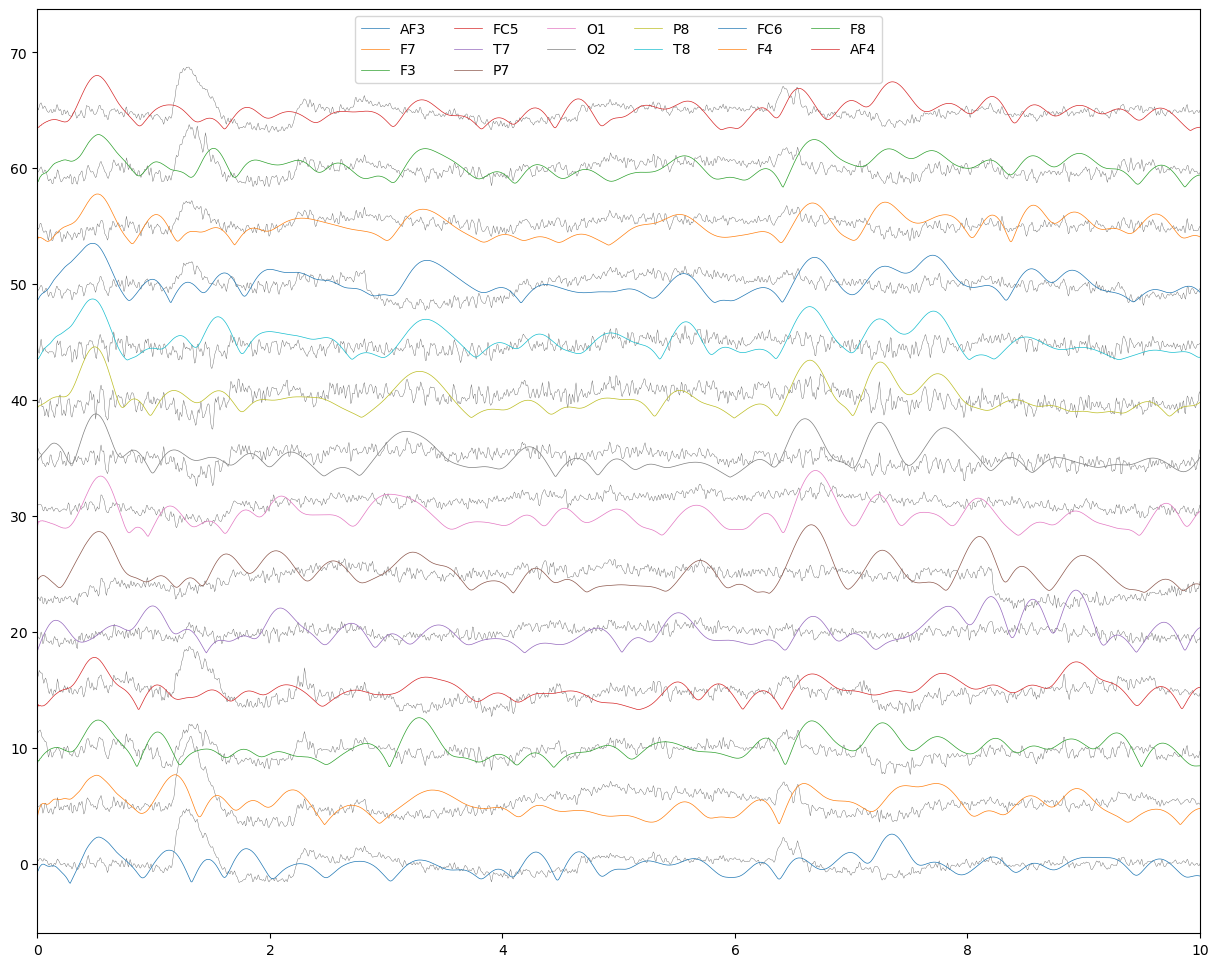

In [109]:
# now that data is clean, extract alpha waves magnitude from the clean signals

# filter the data between 8-12 Hz (note that data has been rescaled to original scale after filtering for comparable visualization)
b, a = signal.butter(6, [8 / Fs * 2, 12 / Fs * 2], btype='bandpass')
X_interp_clean_alpha = X_interp_clean.apply(lambda x: signal.filtfilt(b, a, x) / max(abs(signal.filtfilt(b, a, x))) * max(abs(x)), axis=0)

# extract envelope of the Alpha waves
X_interp_clean_alpha = X_interp_clean_alpha.apply(lambda x: np.abs(signal.hilbert(x)), axis=0)
X_interp_clean_alpha.columns = cols

plot_data([X_interp_clean, X_interp_clean_alpha], xlim=[0, 10])

In [111]:
import seaborn as sns

<Axes: >

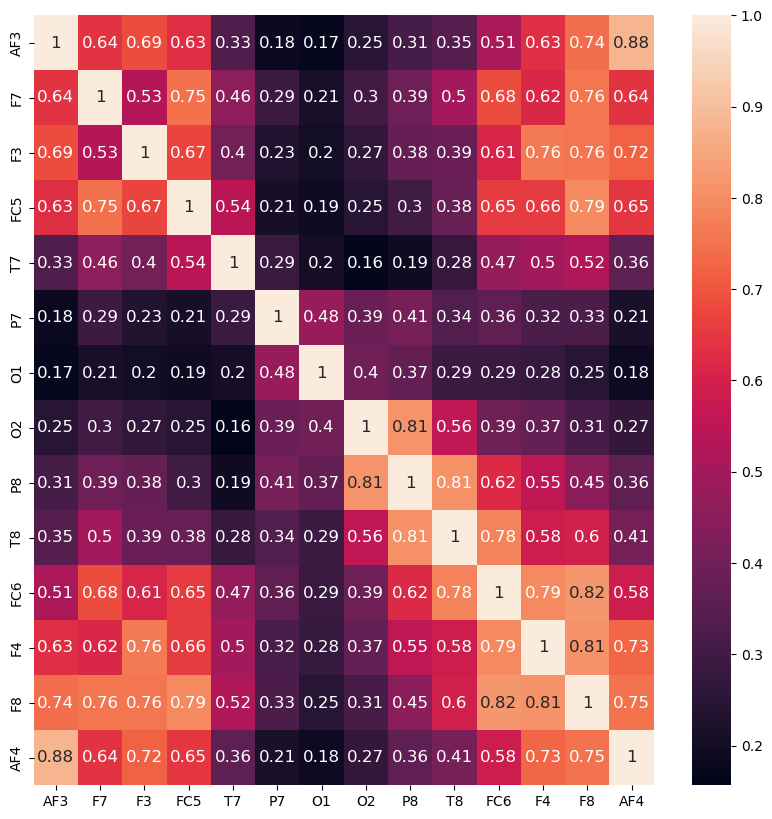

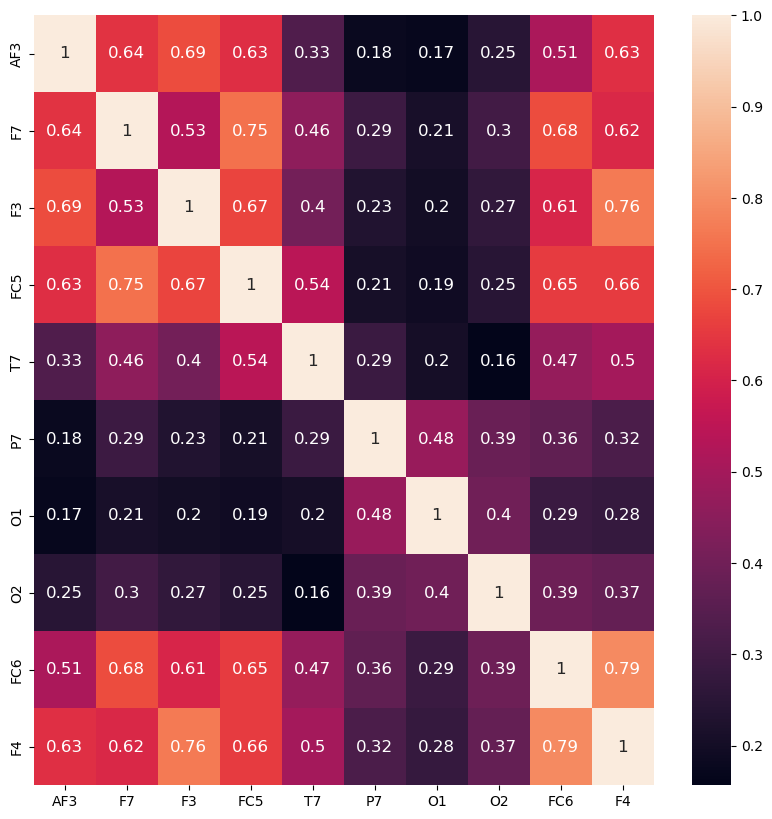

In [112]:
# drop features with high correlations
X = X_interp_clean_alpha
Cols_corr = X.corr()

# plot correlations of the cols
plt.figure( figsize=(10,10) )
sns.heatmap(Cols_corr, annot=True, annot_kws={'fontsize':12})

# exclude columns with high correlation
cols_drop_ind = [0] * len(cols)
for i in range(len(cols)):
    for j in range(len(cols)):
        if (i<j) & abs( Cols_corr.iloc[i, j] >= 0.8):
            cols_drop_ind[j] = 1

cols_drop = [cols[ind] for ind in range(len(cols_drop_ind)) if cols_drop_ind[ind]]
X.drop(columns=cols_drop, inplace=True)

plt.figure( figsize=(10,10) )
sns.heatmap(X.corr(), annot=True, annot_kws={'fontsize':12})

In [114]:
Y = df['eyeDetection']

Variance ratio explained by the components is :[0.56941869 0.19168228]


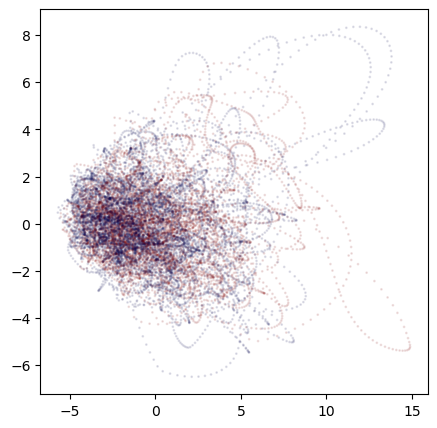

In [115]:
# just to check if the labels are linearly separable with less features! (Seems like we can't!)

from sklearn.decomposition import PCA
from matplotlib import interactive

N = 2
pca = PCA(n_components=N)
X_pca = pd.DataFrame( pca.fit_transform(X), columns=['PC' + str(i+1) for i in range(N)])
print( 'Variance ratio explained by the components is :' + str(pca.explained_variance_ratio_))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
_ = ax.scatter(X_pca['PC1'], X_pca['PC2'], s = 1, c=Y, cmap='seismic', alpha=0.1)

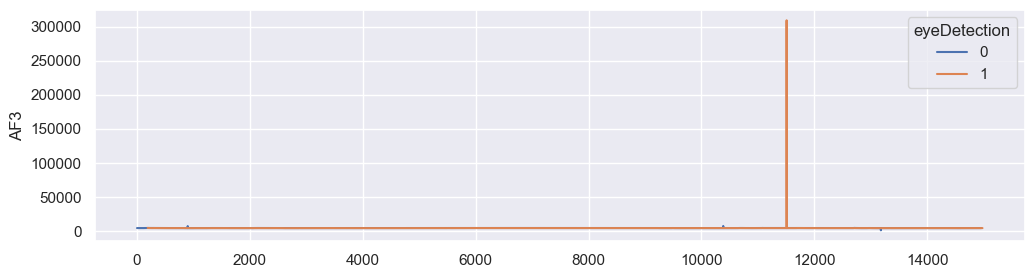

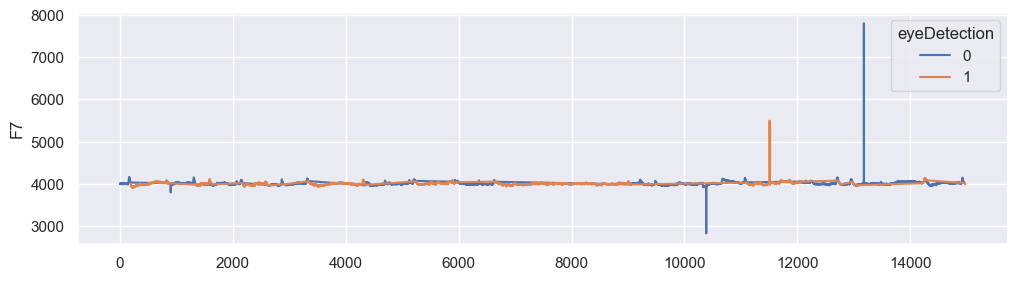

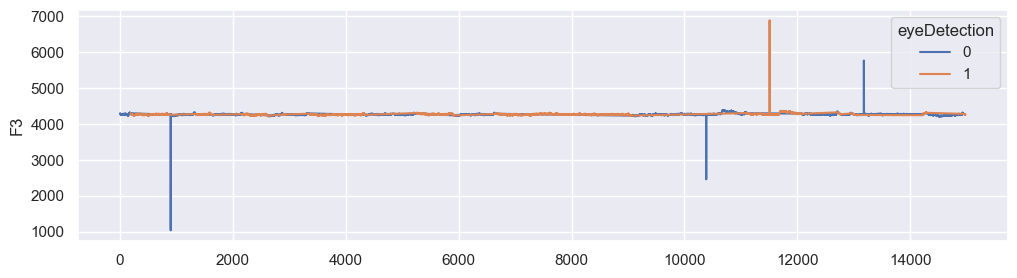

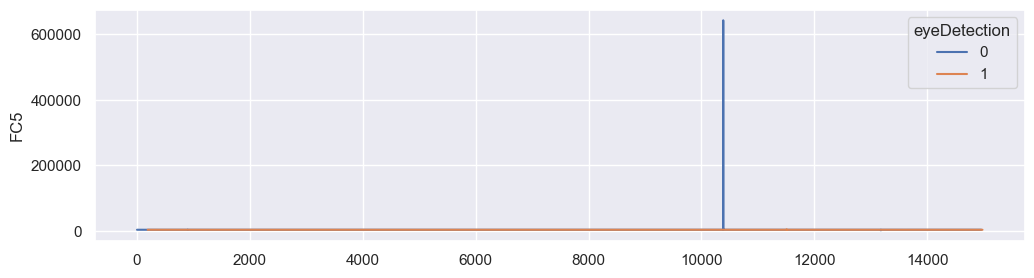

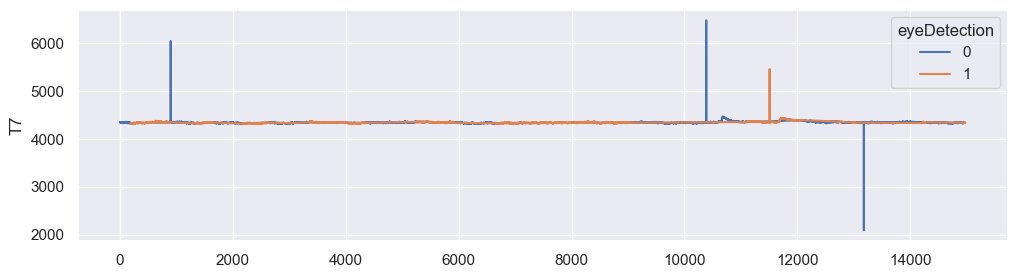

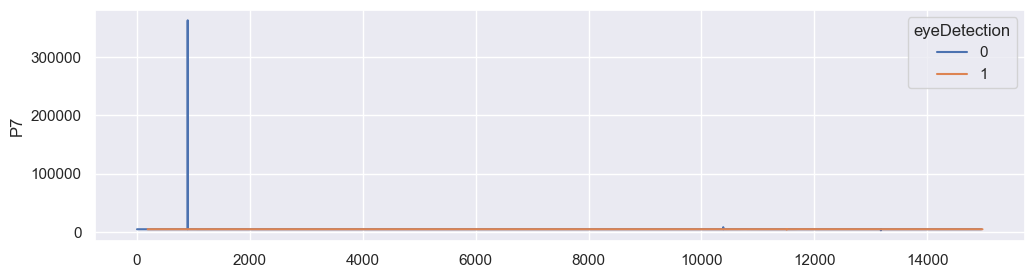

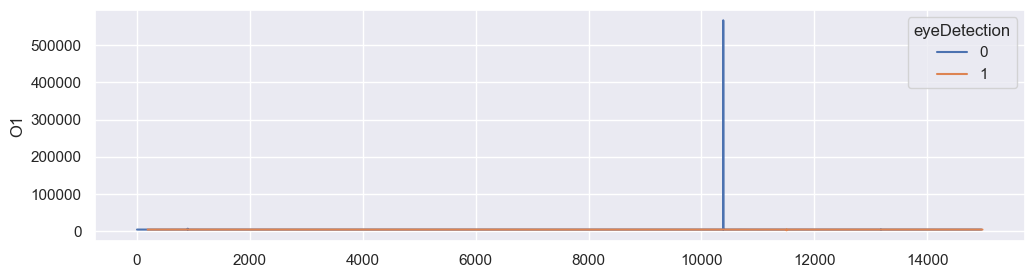

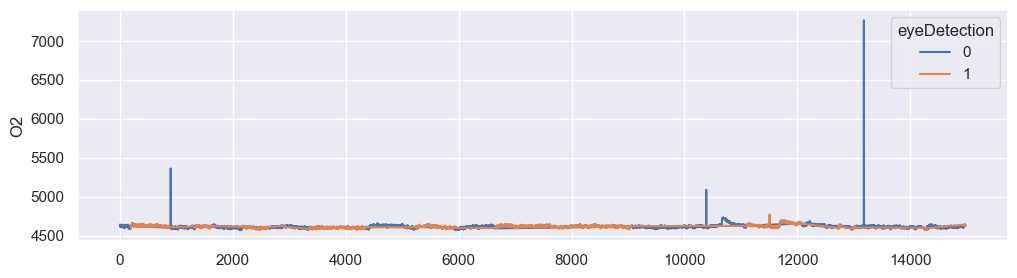

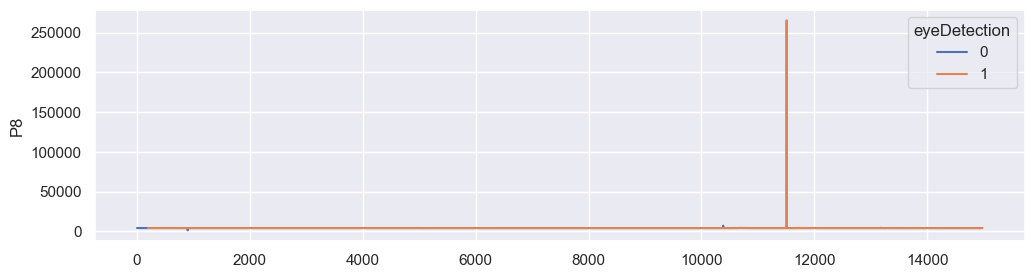

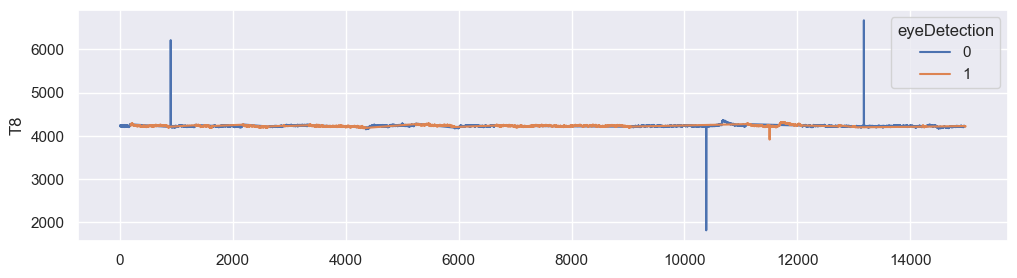

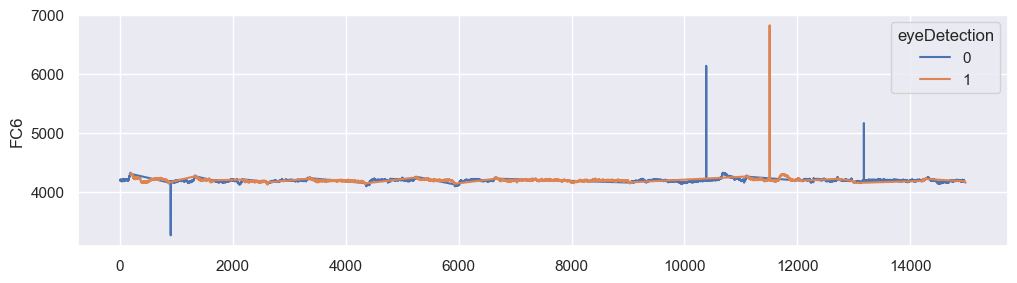

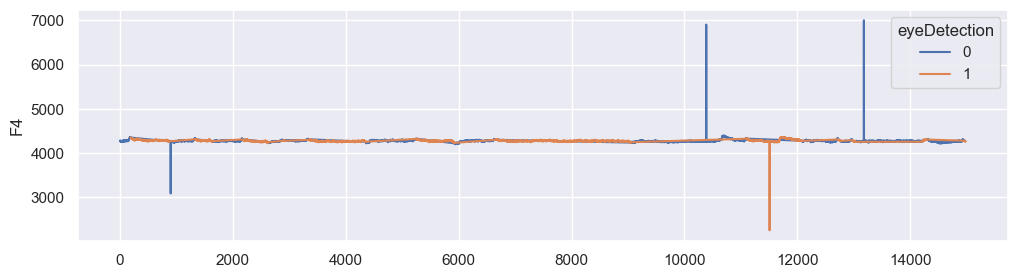

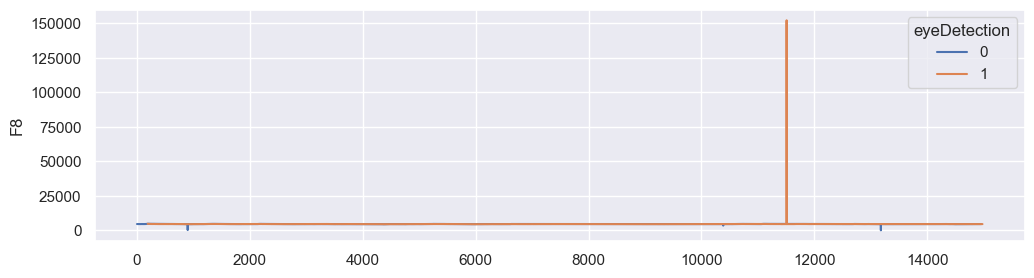

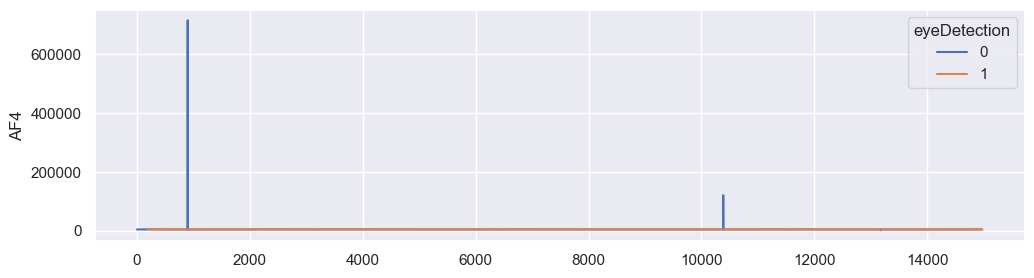

In [9]:
sns.set_theme(style='darkgrid')
for col in df.columns[0:-1]:
    plt.figure(figsize=(12, 3))
    sns.lineplot(x=df.index, y=col, data=df, hue="eyeDetection")
    plt.show()

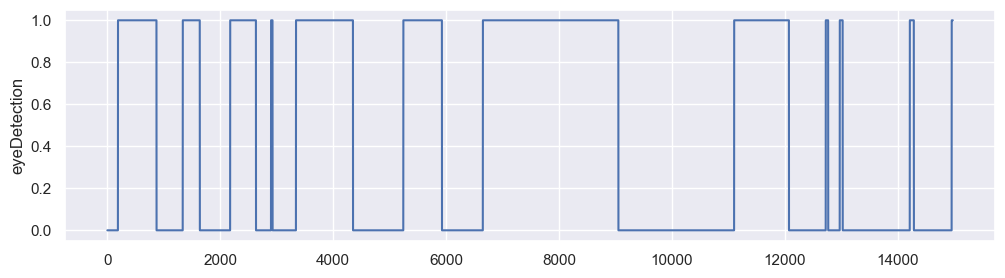

In [10]:
plt.figure(figsize=(12, 3))
sns.lineplot(x=df.index, y=df.columns[-1], data=df)
plt.show()

In [11]:
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 10).all(axis=1)
df_filtered = df[filtered_entries].reset_index(drop=True)
df_filtered.head(2)

AF3       F7       F3      FC5       T7       P7       O1       O2  \
0  4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03   
1  4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   

        P8       T8      FC6       F4       F8      AF4  eyeDetection  
0  4222.05  4238.46  4211.28  4280.51  4635.90  4393.85             0  
1  4210.77  4226.67  4207.69  4279.49  4632.82  4384.10             0

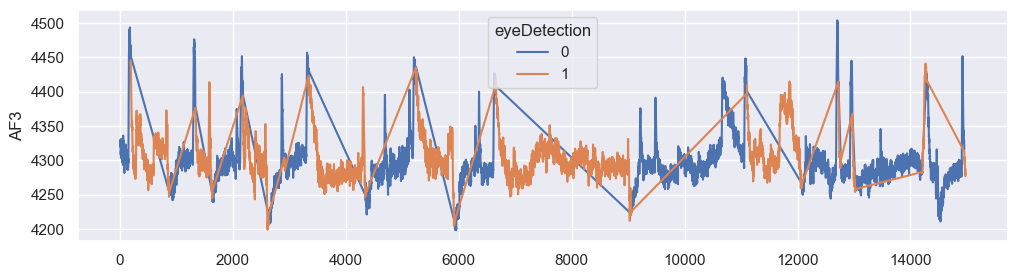

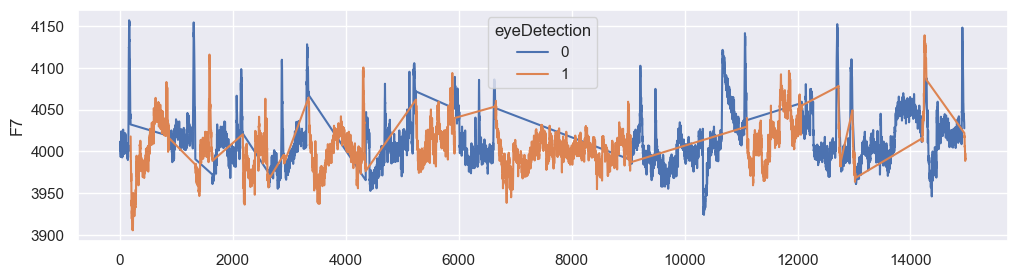

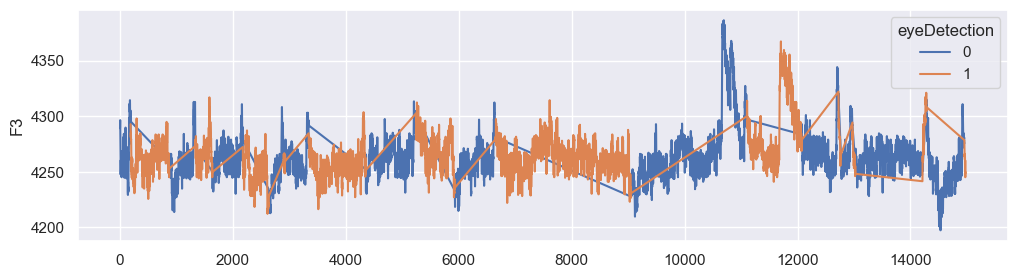

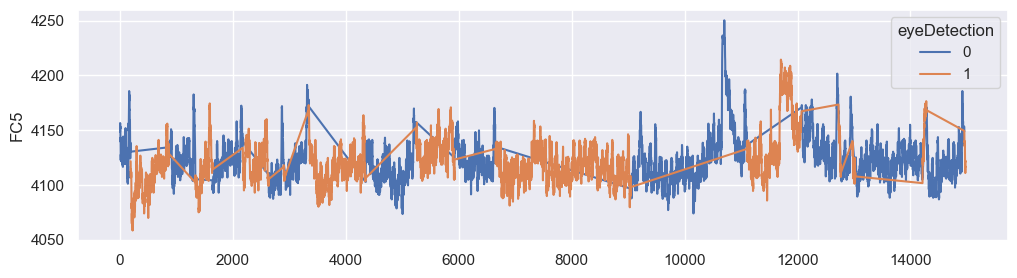

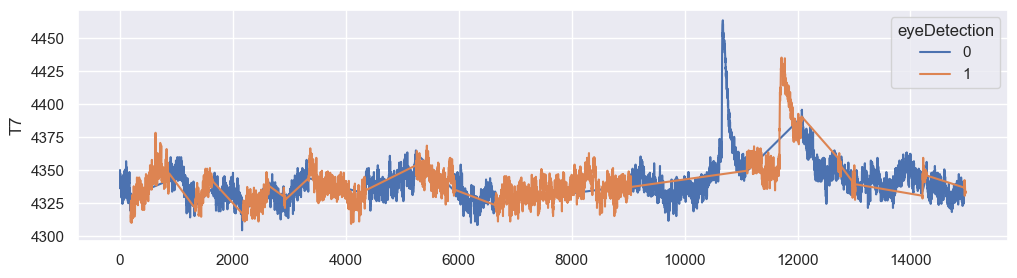

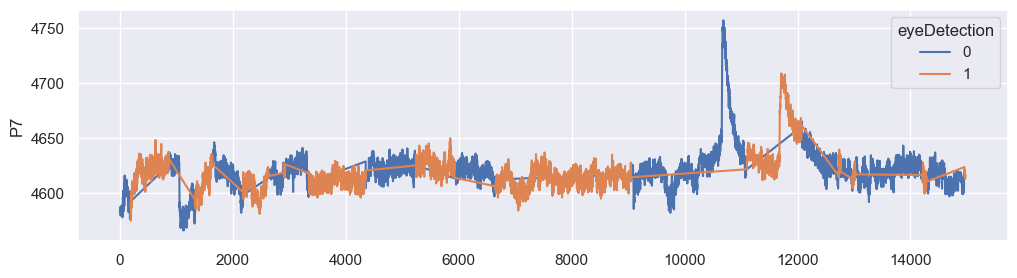

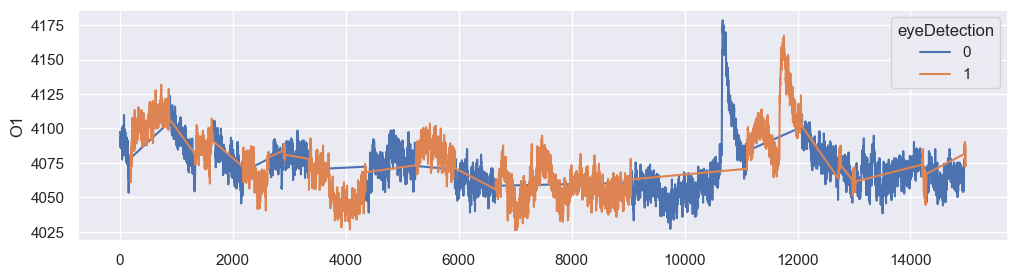

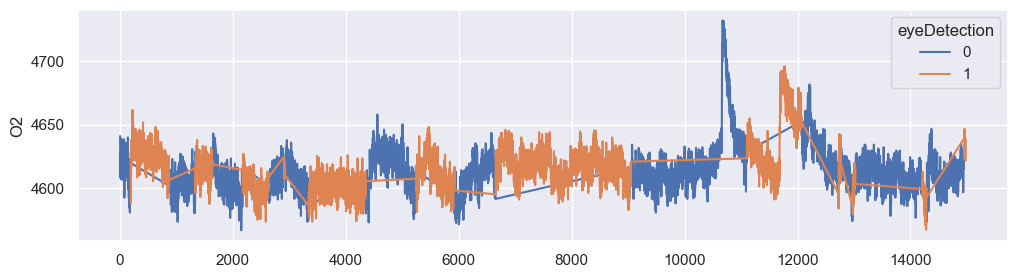

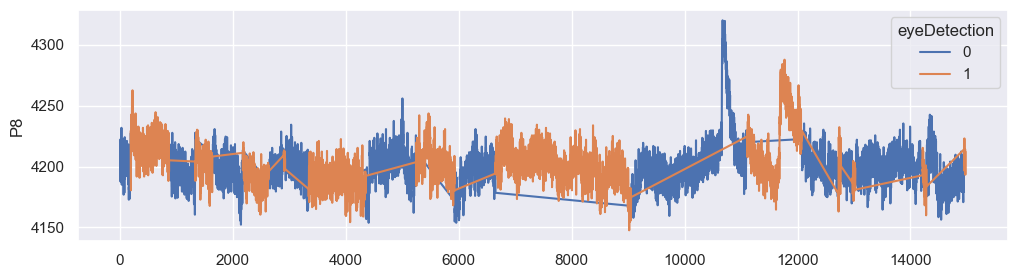

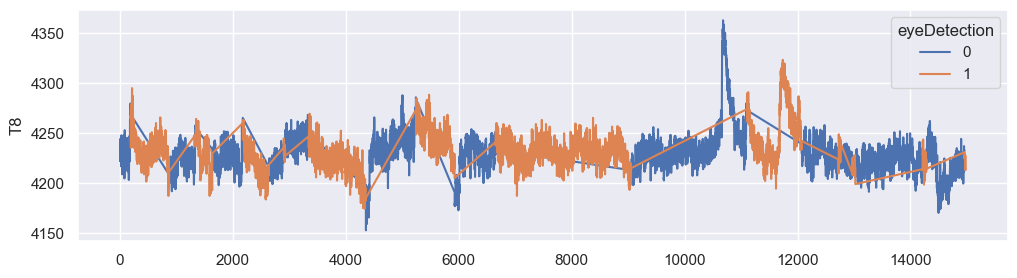

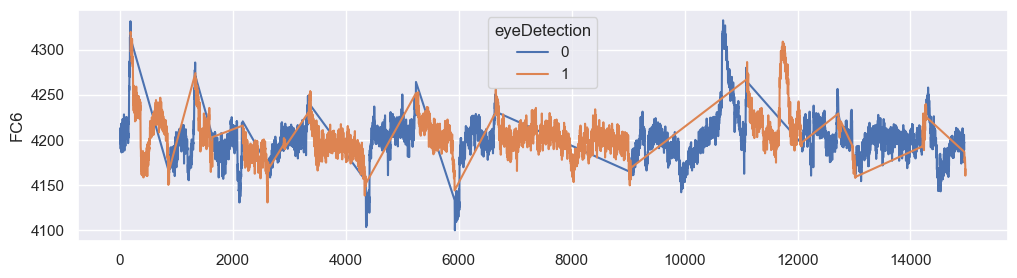

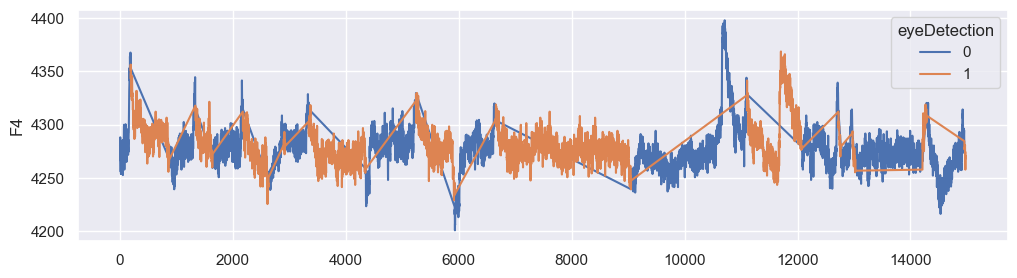

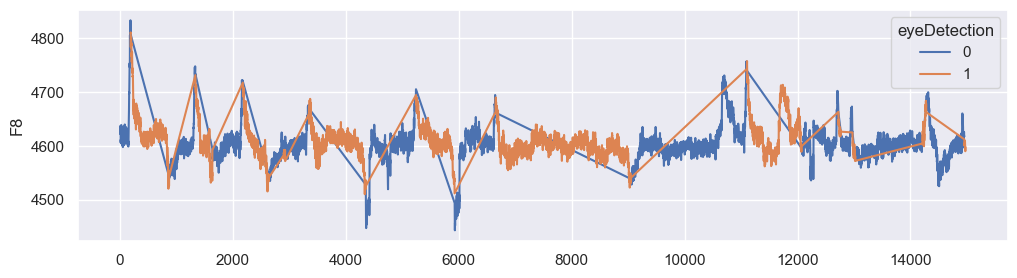

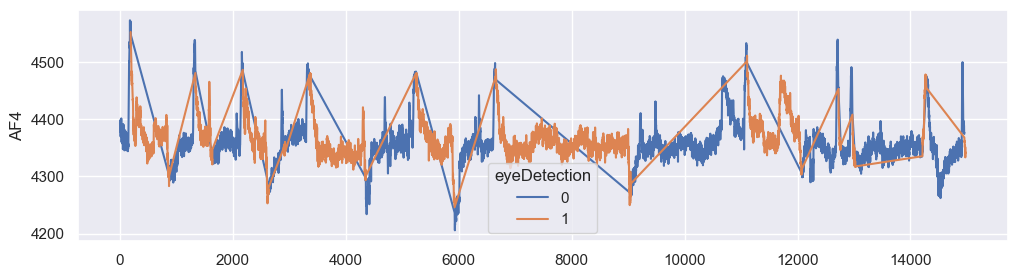

In [13]:
df = df_filtered.copy()
for col in df.columns[:-1]:
    plt.figure(figsize=(12, 3))
    sns.lineplot(x=df.index, y=col, data=df, hue="eyeDetection")
    plt.show()

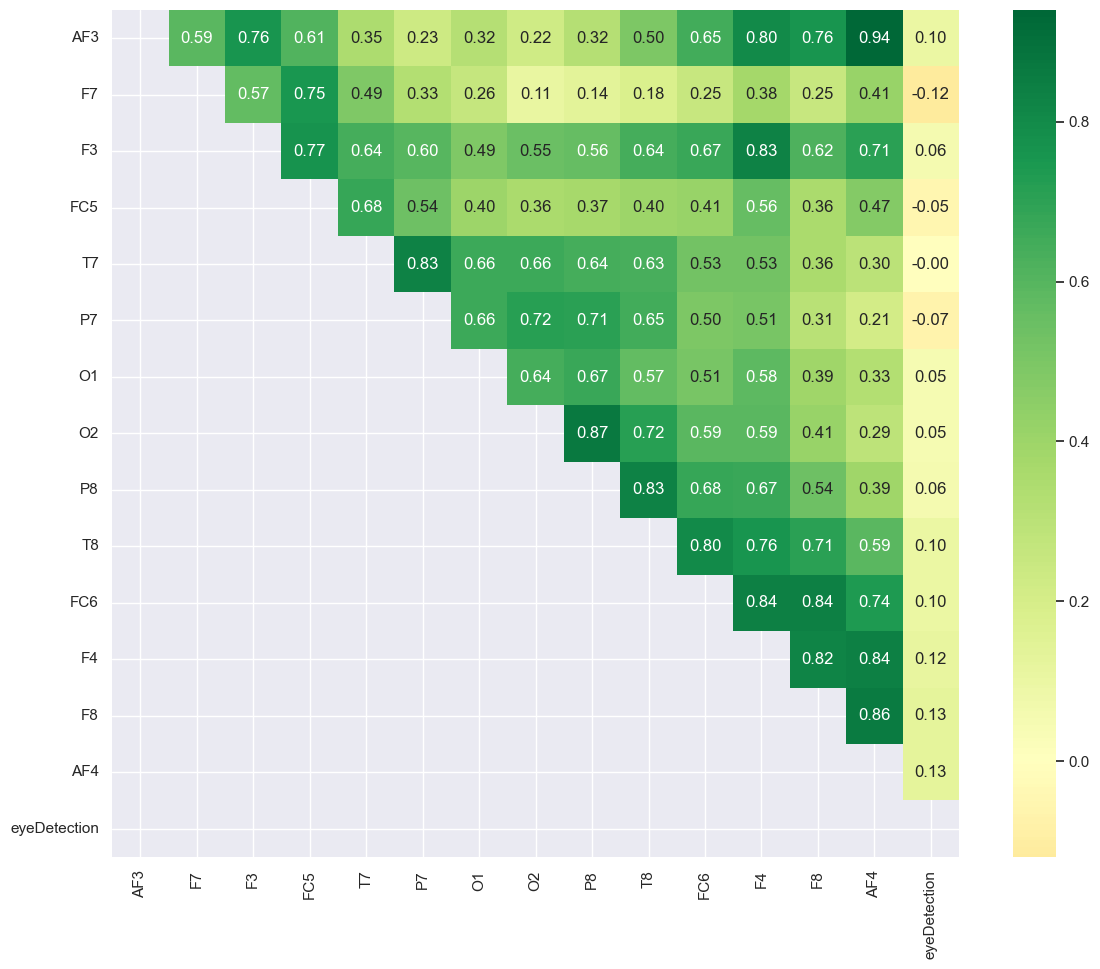

In [14]:
# Calculate pairwise-correlation
corr_matrix = df.corr().round(2)

# Create a mask
mask = np.tril(np.ones_like(corr_matrix, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center='light', as_cmap=True)

plt.figure(figsize=(14, 11))
sns.heatmap(corr_matrix, mask=mask, center=0, annot=True, 
            fmt='.2f', square=True, cmap='RdYlGn')
plt.show()

In [15]:
X = df.iloc[:, :-1] # independent variable
X.columns

Index(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4'],
      dtype='object')

In [16]:
y = np.array(df.iloc[:, -1]) # dependent variable
y = y.reshape(-1, 1) # reshaping data
y

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=int64)

In [17]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
print(colored("Shapes of our variables", "green", attrs=['bold', 'underline']))
print(colored(f"\tX_train: {X_train.shape[0]} rows for {X_train.shape[1]} columns", "blue"))
print(colored(f"\tX_test: {X_test.shape[0]} rows for {X_test.shape[1]} columns", "red"))
print(colored(f"\ty_train: {y_train.shape[0]} rows for {1} columns", "blue"))
print(colored(f"\ty_test: {y_test.shape[0]} rows for {1} columns", "red"))

Shapes of our variables
	X_train: 11980 rows for 14 columns
	X_test: 2996 rows for 14 columns
	y_train: 11980 rows for 1 columns
	y_test: 2996 rows for 1 columns


# Machine Learning

In [127]:
from sklearn.metrics import classification_report
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt

In [128]:
def plot_classification_report(y_test, y_pred, title='Classification Report', figsize=(8, 6), dpi=70, save_fig_path=None, **kwargs):
    """
    Plot the classification report of sklearn
    
    Parameters
    ----------
    y_test : pandas.Series of shape (n_samples,)
        Targets.
    y_pred : pandas.Series of shape (n_samples,)
        Predictions.
    title : str, default = 'Classification Report'
        Plot title.
    fig_size : tuple, default = (8, 6)
        Size (inches) of the plot.
    dpi : int, default = 70
        Image DPI.
    save_fig_path : str, defaut=None
        Full path where to save the plot. Will generate the folders if they don't exist already.
    **kwargs : attributes of classification_report class of sklearn
    
    Returns
    -------
        fig : Matplotlib.pyplot.Figure
            Figure from matplotlib
        ax : Matplotlib.pyplot.Axe
            Axe object from matplotlib
    """    
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        
    clf_report = classification_report(y_test, y_pred, output_dict=True, **kwargs)
    keys_to_plot = [key for key in clf_report.keys() if key not in ('accuracy', 'macro avg', 'weighted avg')]
    df = pd.DataFrame(clf_report, columns=keys_to_plot).T
    #the following line ensures that dataframe are sorted from the majority classes to the minority classes
    df.sort_values(by=['support'], inplace=True) 
    
    #first, let's plot the heatmap by masking the 'support' column
    rows, cols = df.shape
    mask = np.zeros(df.shape)
    mask[:,cols-1] = True
 
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="YlGn", fmt='.3g',
            vmin=0.0,
            vmax=1.0,
            linewidths=2, linecolor='white'
                    )
    
    #then, let's add the support column by normalizing the colors in this column
    mask = np.zeros(df.shape)
    mask[:,:cols-1] = True    
    
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="YlGn", cbar=False,
            linewidths=2, linecolor='white', fmt='.0f',
            vmin=df['support'].min(),
            vmax=df['support'].sum(),         
            norm=mpl.colors.Normalize(vmin=df['support'].min(),
                                      vmax=df['support'].sum())
                    ) 
            
    plt.title(title)
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 360)
         
    if (save_fig_path != None):
        path = pathlib.Path(save_fig_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_fig_path)
    
    return fig, ax

## Descision Tree

We will first try with a *DescisionTreeClassifier* coming again from *scikit-learn*

In [20]:
dct = DecisionTreeClassifier()
dct.fit(X_train, y_train)
y_pred = dct.predict(X_test)

In [21]:
accuracy_score(y_test, y_pred)

0.8274365821094793

### Confusion matrix

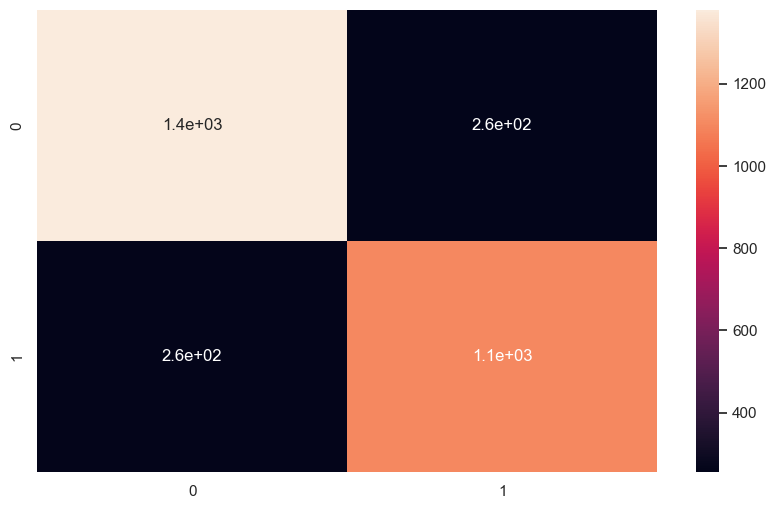

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True)
plt.show()

Based on this confusion matrix and the accuracy score we got, we can assume that the model is quite performant to predict if an eye will be opened or not depending on features we fed the network with.

## Logistic Regression

In [25]:
lr = LogisticRegression()
lr.fit(X_train , y_train)
y_pred = lr.predict(X_test)
lr.score(X_test, y_test)

c:\Users\mahan\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6255006675567423

### Cross validation

Using cross validation technique to have an idea of the best batch to take in order to get the best accuracy.

 Cross-validation is a technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data. Use cross-validation to detect overfitting, ie, failing to generalize a pattern

In [26]:
scores = cross_val_score(lr, X, y, cv=5, scoring=None)
scores

c:\Users\mahan\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mahan\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mahan\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mahan\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

array([0.56141522, 0.47245409, 0.3572621 , 0.22838063, 0.45509182])

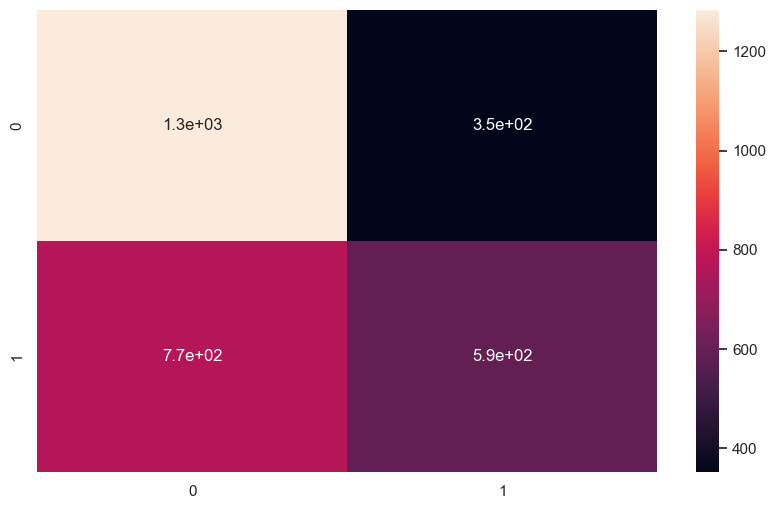

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True)
plt.show()

## XGBoost

Using an XGBoost Classifier.

In [28]:
xgbc = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
predictor_xgb = xgbc.fit(X_train, y_train)
y_pred = predictor_xgb.predict(X_test)
accuracy_score(y_test, y_pred)

0.9359145527369827

And we get 93% of accuracy with an XGBoost Classifier !

### Visualize the prediction

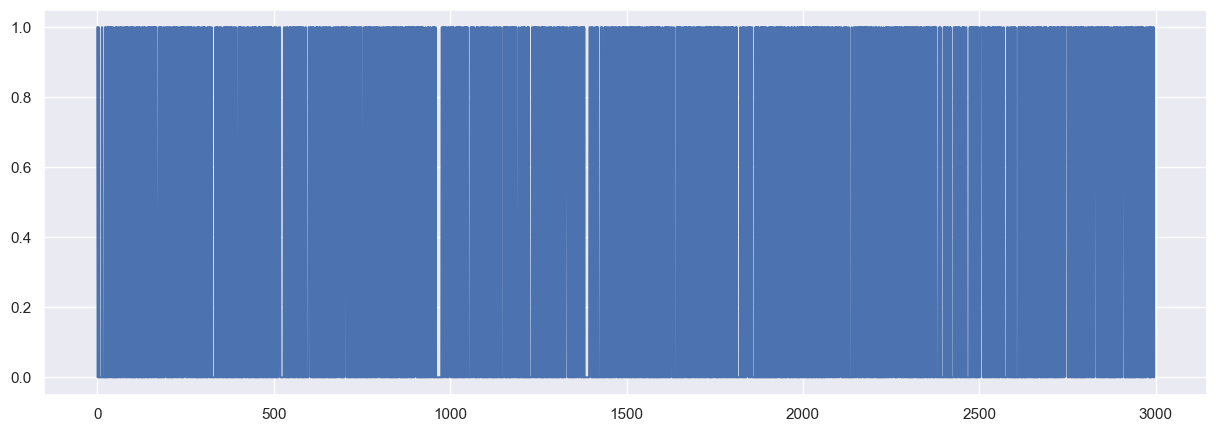

In [30]:
df_ypred = pd.DataFrame(y_pred)
plt.figure(figsize=(15, 5))
sns.lineplot(x=df_ypred.index, y=y_pred)
plt.show()

## SVM

In [116]:
# train an SVM to classify
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# split train test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=48, test_size=0.2, stratify=Y, shuffle=True)

# normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [117]:
from sklearn.metrics import roc_auc_score

# train with grid search
svc = SVC()
parameters = {'gamma': [0.1, 1, 10], 'C': [0.1, 1, 10]}
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

# predict labels
y_pred = clf.predict(X_test)

# extract accuracy (r2 score)
results = roc_auc_score(y_test, y_pred)

# print score
print( 'Score is: ' + str( results ) )
print( 'Best params for the kernel SVM is: ' + str(clf.best_params_) )

Score is: 0.997907317633337
Best params for the kernel SVM is: {'C': 10, 'gamma': 1}


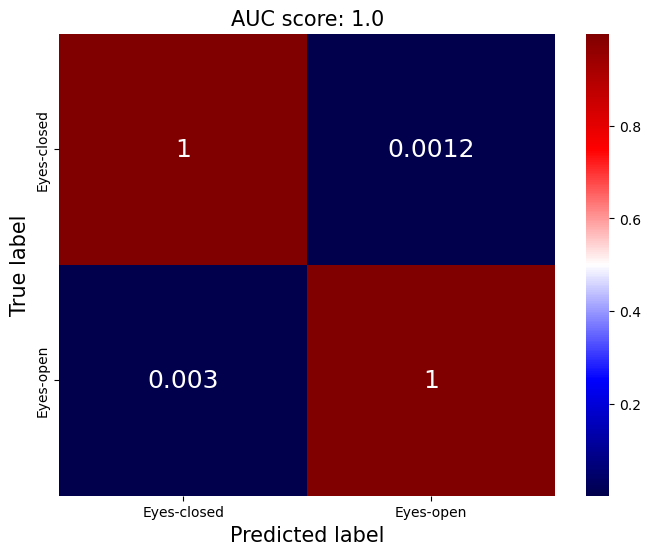

In [118]:
from sklearn.metrics import confusion_matrix

# confusion matrix estimation
conf = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8,6))
sns.heatmap(conf, annot=True, cmap='seismic', annot_kws={'fontsize':18})
_ = plt.title( 'AUC score: ' + str(round(results, 2) ), fontsize=15)
_ = plt.xticks(ticks=[0.5, 1.5], labels=['Eyes-closed', 'Eyes-open'])
_ = plt.yticks(ticks=[0.5, 1.5], labels=['Eyes-closed', 'Eyes-open'])
_ = plt.ylabel('True label', fontsize=15)
_ = plt.xlabel('Predicted label', fontsize=15)

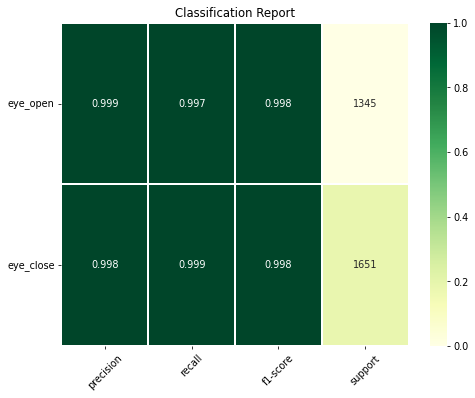

In [130]:
fig, ax = plot_classification_report(y_test, y_pred, 
                    title='Classification Report',
                    figsize=(8, 6), dpi=70,
                    target_names=["eye_close","eye_open"])

# Deep Laerning and Neural Network

## Neural Network

In [32]:
from keras.models import Sequential

In [33]:
nn = Sequential()
nn.add(Dense(100, input_shape=(14,), activation='relu'))
nn.add(Dense(14, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))

nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1500      
                                                                 
 dense_1 (Dense)             (None, 14)                1414      
                                                                 
 dense_2 (Dense)             (None, 1)                 15        
                                                                 
Total params: 2929 (11.44 KB)
Trainable params: 2929 (11.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
EPOCHS = 10
BATCH_SIZE = 10
history = nn.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
1198/1198 [==============================] - 3s 2ms/step - loss: 0.4349 - accuracy: 0.7950 - val_loss: 0.4749 - val_accuracy: 0.7647
Epoch 2/10
1198/1198 [==============================] - 2s 2ms/step - loss: 0.4251 - accuracy: 0.7987 - val_loss: 0.4063 - val_accuracy: 0.8228
Epoch 3/10
1198/1198 [==============================] - 3s 2ms/step - loss: 0.4038 - accuracy: 0.8159 - val_loss: 0.3947 - val_accuracy: 0.8268
Epoch 4/10
1198/1198 [==============================] - 3s 2ms/step - loss: 0.3895 - accuracy: 0.8270 - val_loss: 0.3816 - val_accuracy: 0.8204
Epoch 5/10
1198/1198 [==============================] - 2s 2ms/step - loss: 0.3738 - accuracy: 0.8374 - val_loss: 0.3707 - val_accuracy: 0.8381
Epoch 6/10
1198/1198 [==============================] - 3s 2ms/step - loss: 0.3595 - accuracy: 0.8433 - val_loss: 0.3536 - val_accuracy: 0.8461
Epoch 7/10
1198/1198 [==============================] - 3s 3ms/step - loss: 0.3505 - accuracy: 0.8456 - val_loss: 0.3769 - val_accuracy:

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Deep learning

In [39]:
x_train = np.array(X_train).reshape(-1,14,1)
x_test = np.array(X_test).reshape(-1,14,1)

In [40]:
x_train.shape, x_test.shape,y_train.shape,y_test.shape

((11980, 14, 1), (2996, 14, 1), (11980, 1), (2996, 1))

### BILSTM

In [42]:
import keras

In [43]:
inputs = tf.keras.Input(shape=(14,1))

Dense1 = Dense(64, activation = 'relu',kernel_regularizer=keras.regularizers.l2())(inputs)

#Dense2 = Dense(128, activation = 'relu',kernel_regularizer=keras.regularizers.l2())(Dense1)
#Dense3 = Dense(256, activation = 'relu',kernel_regularizer=keras.regularizers.l2())(Dense2)

lstm_1=  Bidirectional(LSTM(256, return_sequences = True))(Dense1)
drop = Dropout(0.3)(lstm_1)
lstm_3=  Bidirectional(LSTM(128, return_sequences = True))(drop)
drop2 = Dropout(0.3)(lstm_3)

flat = Flatten()(drop2)

#Dense_1 = Dense(256, activation = 'relu')(flat)

Dense_2 = Dense(128, activation = 'relu')(flat)
outputs = Dense(1, activation='sigmoid')(Dense_2)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 1)]           0         
                                                                 
 dense_3 (Dense)             (None, 14, 64)            128       
                                                                 
 bidirectional (Bidirection  (None, 14, 512)           657408    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 512)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 14, 256)           656384    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 14, 256)           0     

In [44]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [48]:
def train_model(model,x_train, y_train,x_test,y_test, save_to, epoch = 2):

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
        
        model.compile(optimizer=opt_adam,
                  loss=['binary_crossentropy'],
                  metrics=['accuracy'])
        
        history = model.fit(x_train,y_train,
                        batch_size=20,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule])
        
        saved_model = load_model(save_to + '_best_model.h5')
        
        return model,history

In [50]:
model,history = train_model(model, x_train, y_train,x_test, y_test, save_to= './', epoch = 10) 

Epoch 1/10
599/599 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.5686
Epoch 1: val_accuracy improved from -inf to 0.59513, saving model to .\_best_model.h5


c:\Users\mahan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


599/599 [==============================] - 107s 164ms/step - loss: 0.6861 - accuracy: 0.5686 - val_loss: 0.6787 - val_accuracy: 0.5951 - lr: 0.0010
Epoch 2/10
599/599 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.6452
Epoch 2: val_accuracy improved from 0.59513 to 0.69192, saving model to .\_best_model.h5
599/599 [==============================] - 87s 145ms/step - loss: 0.6319 - accuracy: 0.6452 - val_loss: 0.6019 - val_accuracy: 0.6919 - lr: 9.0484e-04
Epoch 3/10
599/599 [==============================] - ETA: 0s - loss: 0.5485 - accuracy: 0.7203
Epoch 3: val_accuracy improved from 0.69192 to 0.69526, saving model to .\_best_model.h5
599/599 [==============================] - 91s 151ms/step - loss: 0.5485 - accuracy: 0.7203 - val_loss: 0.5306 - val_accuracy: 0.6953 - lr: 8.1873e-04
Epoch 4/10
599/599 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.8014
Epoch 4: val_accuracy improved from 0.69526 to 0.85547, saving model to .\_best_mode

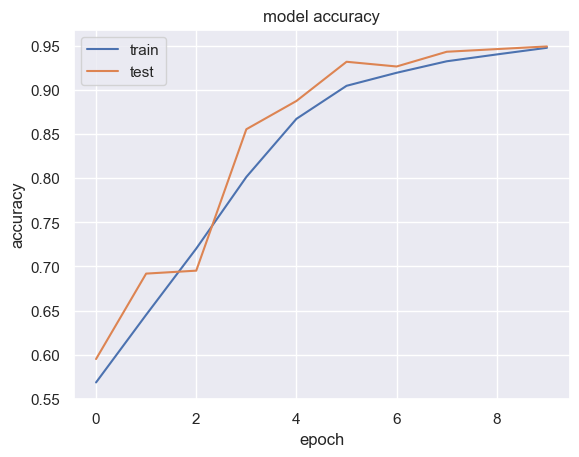

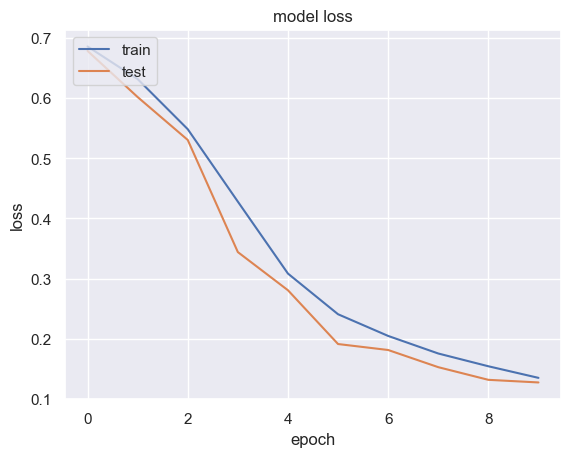

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

94/94 [==============================] - 5s 56ms/step


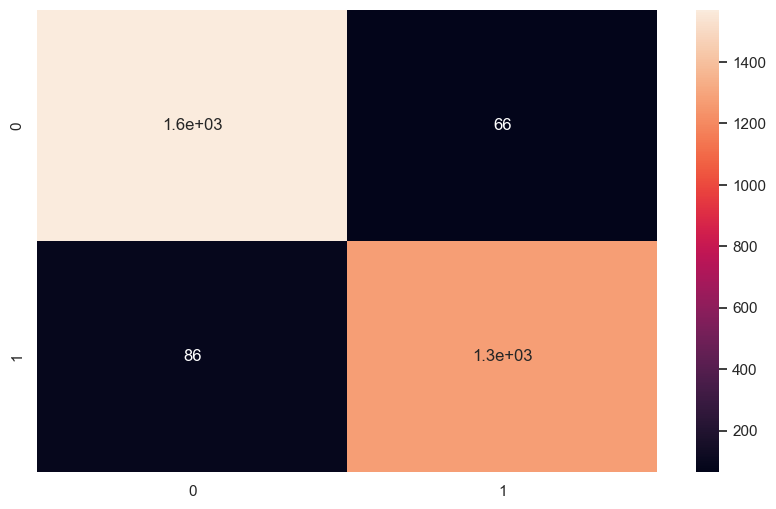

In [53]:
y_pred =model.predict(x_test)
y_pred = np.array(y_pred >= 0.5, dtype = np.int_)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True)
plt.show()

In [54]:
from sklearn.metrics import classification_report

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95      1636
         1.0       0.95      0.94      0.94      1360

    accuracy                           0.95      2996
   macro avg       0.95      0.95      0.95      2996
weighted avg       0.95      0.95      0.95      2996



### BIGRU

In [83]:
inputs = tf.keras.Input(shape=(14,1))

Dense1 = Dense(64, activation = 'relu',kernel_regularizer=keras.regularizers.l2())(inputs)


gru_1=  Bidirectional(GRU(256, return_sequences = True))(Dense1)
drop = Dropout(0.3)(gru_1)
gru_3=  Bidirectional(GRU(128, return_sequences = True))(drop)
drop2 = Dropout(0.3)(gru_3)

flat = Flatten()(drop2)

#Dense_1 = Dense(256, activation = 'relu')(flat)

Dense_2 = Dense(128, activation = 'relu')(flat)
outputs = Dense(1, activation='sigmoid')(Dense_2)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 14, 1)]           0         
                                                                 
 dense_27 (Dense)            (None, 14, 64)            128       
                                                                 
 bidirectional_10 (Bidirect  (None, 14, 512)           494592    
 ional)                                                          
                                                                 
 dropout_15 (Dropout)        (None, 14, 512)           0         
                                                                 
 bidirectional_11 (Bidirect  (None, 14, 256)           493056    
 ional)                                                          
                                                                 
 dropout_16 (Dropout)        (None, 14, 256)           0   

In [84]:
model,history = train_model(model, x_train, y_train,x_test, y_test, save_to= './', epoch = 10) 

Epoch 1/10
599/599 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.5790
Epoch 1: val_accuracy improved from -inf to 0.65721, saving model to .\_best_model.h5


c:\Users\mahan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


599/599 [==============================] - 72s 106ms/step - loss: 0.6752 - accuracy: 0.5790 - val_loss: 0.6021 - val_accuracy: 0.6572 - lr: 0.0010
Epoch 2/10
599/599 [==============================] - ETA: 0s - loss: 0.4857 - accuracy: 0.7636
Epoch 2: val_accuracy improved from 0.65721 to 0.85848, saving model to .\_best_model.h5
599/599 [==============================] - 62s 104ms/step - loss: 0.4857 - accuracy: 0.7636 - val_loss: 0.3326 - val_accuracy: 0.8585 - lr: 9.0484e-04
Epoch 3/10
599/599 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.8678
Epoch 3: val_accuracy improved from 0.85848 to 0.90721, saving model to .\_best_model.h5
599/599 [==============================] - 70s 118ms/step - loss: 0.3097 - accuracy: 0.8678 - val_loss: 0.2148 - val_accuracy: 0.9072 - lr: 8.1873e-04
Epoch 4/10
599/599 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9104
Epoch 4: val_accuracy improved from 0.90721 to 0.92724, saving model to .\_best_model

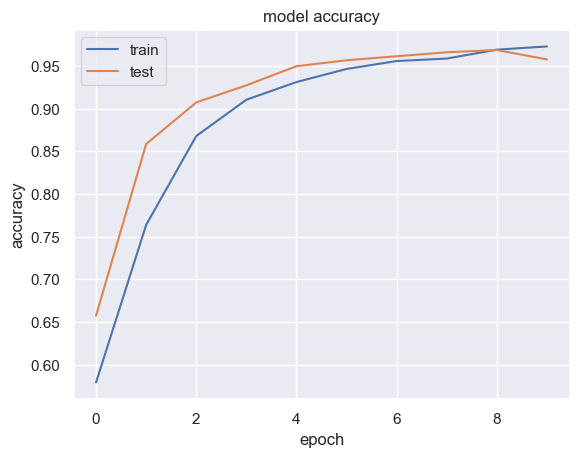

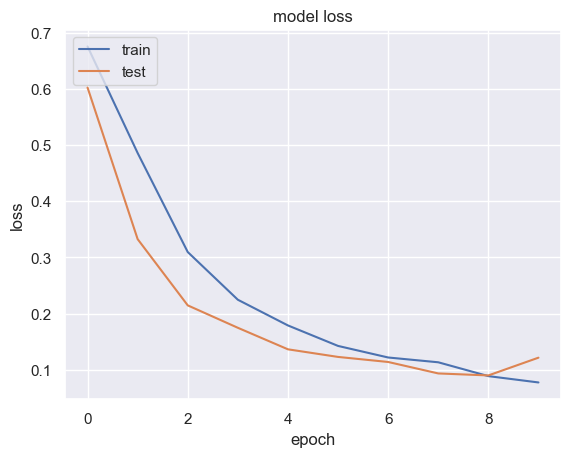

In [90]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

94/94 [==============================] - 5s 36ms/step


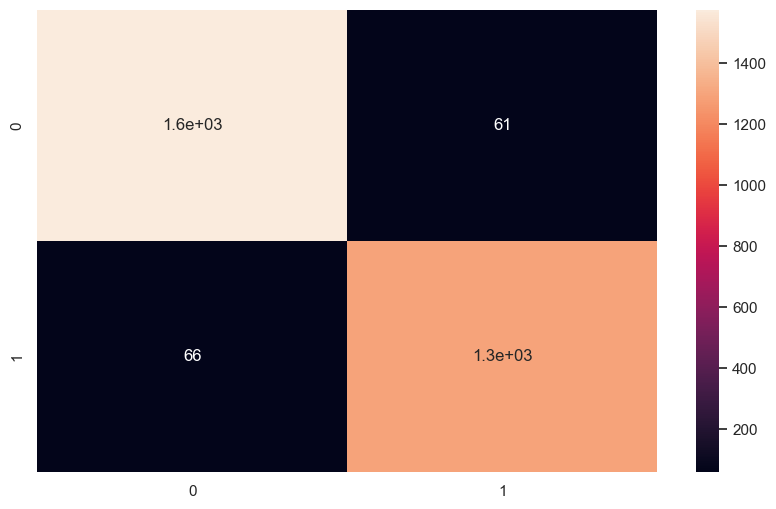

In [86]:
y_pred =model.predict(x_test)
y_pred = np.array(y_pred >= 0.5, dtype = np.int_)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True)
plt.show()

In [100]:
from sklearn.metrics import classification_report

In [88]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      1636
         1.0       0.95      0.95      0.95      1360

    accuracy                           0.96      2996
   macro avg       0.96      0.96      0.96      2996
weighted avg       0.96      0.96      0.96      2996



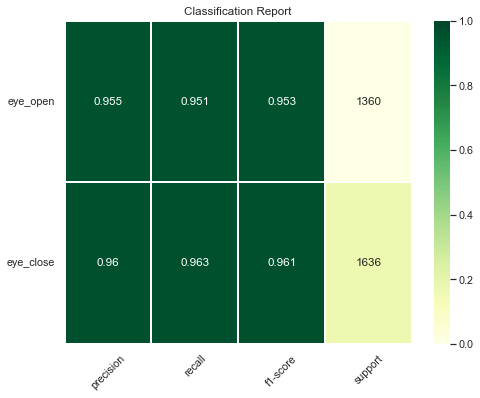

In [115]:
fig, ax = plot_classification_report(y_test, y_pred, 
                    title='Classification Report',
                    figsize=(8, 6), dpi=70,
                    target_names=["eye_close","eye_open"], 
                    save_fig_path = "classificationreport_plot.png")

GRU has fewer gates and fewer parameters than LSTM, which makes it simpler and faster, but also less powerful and adaptable. LSTM has a separate cell state and output, which allows it to store and output different information, while GRU has a single hidden state that serves both 
purposes, which may limit its capacity.

In this case BIGRU has better performance and lower size than BILSTM

### CNN1D-BILSTM

#### same input

In [57]:
from keras.models import Model
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, concatenate, Input

In [79]:
# Define input shape
input_length = 14
input_dim = 1

# Define number of classes
num_classes = 1

# Define input layer
input_layer = Input(shape=(input_length, input_dim))

#DenseX = Dense(64, activation = 'relu',kernel_regularizer=keras.regularizers.l2())(input_layer)

# Add the CNN layer
conv_layer1 = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
pooling_layer1 = MaxPooling1D(pool_size=2)(conv_layer1)
conv_layer2 = Conv1D(filters=32, kernel_size=3, activation='relu')(pooling_layer1)
pooling_layer2 = MaxPooling1D(pool_size=2)(conv_layer2)

# Add another flatten layer
flatten_layer1 = Flatten()(pooling_layer2)

# Add the BILSTM layer
bilstm_layer_1 = LSTM(256, return_sequences = True)(input_layer)
drop1 = Dropout(0.1)(bilstm_layer_1)
bilstm_layer_2=  LSTM(128, return_sequences = True)(drop1)
drop2 = Dropout(0.1)(bilstm_layer_2)
flatten_layer2 = Flatten()(drop2)


# Concatenate the flatten layers
concat_layer = concatenate([flatten_layer1, flatten_layer2])
# Dense layer 1
dense = Dense(128, activation = 'relu')(concat_layer)
# Add a dense layer for classification
output_layer = Dense(units=num_classes, activation='softmax')(dense)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

In [80]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 14, 1)]              0         []                            
                                                                                                  
 conv1d_10 (Conv1D)          (None, 12, 32)               128       ['input_11[0][0]']            
                                                                                                  
 lstm_13 (LSTM)              (None, 14, 256)              264192    ['input_11[0][0]']            
                                                                                                  
 max_pooling1d_10 (MaxPooli  (None, 6, 32)                0         ['conv1d_10[0][0]']           
 ng1D)                                                                                      

In [ ]:
# Compile and train model 
model,history = train_model(model, x_train, y_train,x_test, y_test, save_to= './', epoch = 10) 

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne

In [90]:
df.iloc[0][-1]

0.0

#### EEG head topographic

Creating RawArray with float64 data, n_channels=14, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


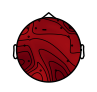

(<matplotlib.image.AxesImage at 0x2287b82e450>,
 <matplotlib.contour.QuadContourSet at 0x2287b82c390>)

In [88]:
data = {'electrode': df.columns.values[:-1].tolist(),
        'value': df.iloc[:, :-1].values.tolist()[0]}
newdf = pd.DataFrame(data)
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(ch_names=newdf['electrode'].tolist(), sfreq=14, ch_types='eeg')
raw = mne.io.RawArray(np.zeros((len(newdf), 1)), info)
raw.set_montage(montage)
raw._data[:, 0] = newdf['value'].values
mne.viz.plot_topomap(raw.get_data()[:, 0], pos=raw.info, outlines='head', show=True)

In [89]:
df.iloc[200][-1]

1.0

Creating RawArray with float64 data, n_channels=14, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


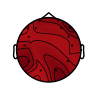

(<matplotlib.image.AxesImage at 0x228723195d0>,
 <matplotlib.contour.QuadContourSet at 0x22877c7a610>)

In [87]:
data = {'electrode': df.columns.values[:-1].tolist(),
        'value': df.iloc[:, :-1].values.tolist()[200]}
newdf = pd.DataFrame(data)
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(ch_names=newdf['electrode'].tolist(), sfreq=14, ch_types='eeg')
raw = mne.io.RawArray(np.zeros((len(newdf), 1)), info)
raw.set_montage(montage)
raw._data[:, 0] = newdf['value'].values
mne.viz.plot_topomap(raw.get_data()[:, 0], pos=raw.info, outlines='head', show=True)

In [69]:
# Create MNE Info object
n_channels = len(df.columns.values[:-1].tolist())
sfreq = 1000  # Sample rate in Hz
info = mne.create_info(ch_names=df.columns.values[:-1].tolist(), sfreq=sfreq)

# Convert the data to a numpy array
np_data = df.iloc[:, :-1].values

# Create the raw MNE object
raw = mne.io.RawArray(np_data, info)
# Plotting topographic maps for each time step
times = np.arange(0, np_data.shape[0]) / sfreq  # Time points for each time step

fig, axes = plt.subplots(nrows=len(times), ncols=1, figsize=(10, 6))
for idx, ax in enumerate(axes):
    t = times[idx]
    mne.viz.plot_topomap(
        data=np_data[idx],
        pos=raw.info,
        axes=ax,
        show=False,
        contours=0,
        outlines='head',
        vmin=np.min(np_data),
        vmax=np.max(np_data),
        cmap='viridis',
        time_unit='s',
        scalings='auto'
    )
    ax.set_title(f'Time: {t:.2f} s')

plt.tight_layout()
plt.show()

ValueError: len(data) (14980) does not match len(info["ch_names"]) (14)

### Transformer